In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, f1_score

from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
data = pd.read_csv('./data/churndata_processed.csv')

data.shape

(7043, 23)

In [3]:
data.columns

Index(['months', 'multiple', 'gb_mon', 'security', 'backup', 'protection',
       'support', 'unlimited', 'contract', 'paperless', 'monthly',
       'satisfaction', 'churn_value', 'payment_Credit Card',
       'payment_Mailed Check', 'internet_type_DSL',
       'internet_type_Fiber Optic', 'internet_type_None', 'offer_Offer A',
       'offer_Offer B', 'offer_Offer C', 'offer_Offer D', 'offer_Offer E'],
      dtype='object')

In [4]:
X = data.drop(['churn_value'], axis=1)
y = data['churn_value']

In [5]:
y.value_counts(normalize=True)

churn_value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [6]:
#Create test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Processed 10 samples
Processed 20 samples
Processed 30 samples
Processed 40 samples
Processed 50 samples


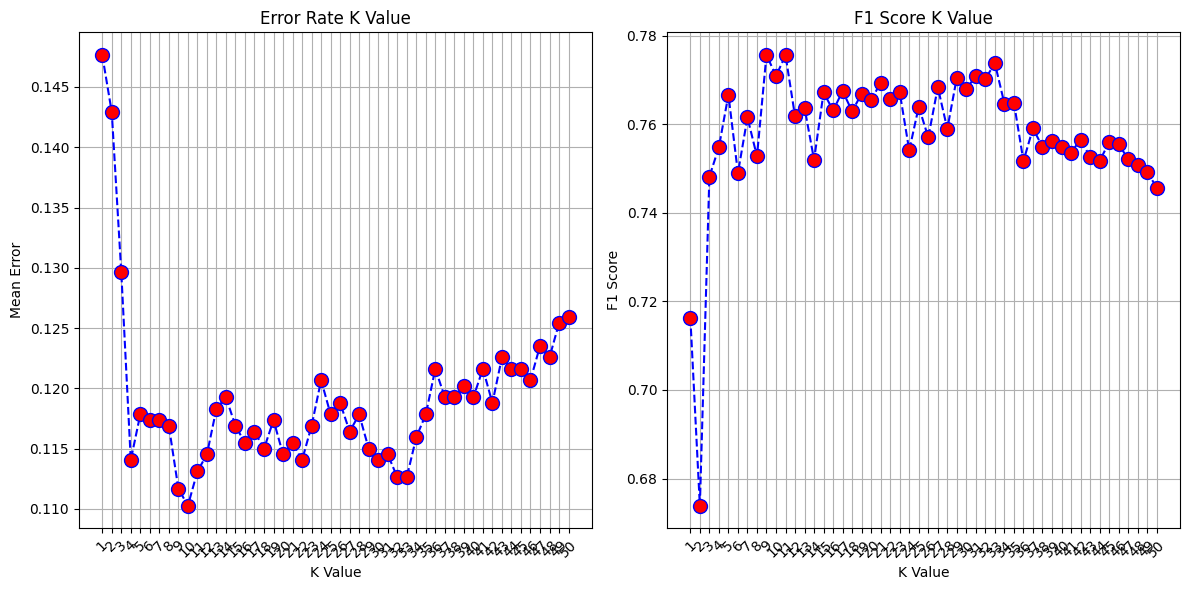

In [7]:
#Create the model
neighbors = np.arange(1, 51, 1)
f1_scores = []
error = [] # 1-accuracy
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))
    error.append(1 - accuracy_score(y_test, y_pred))
    if(i % 10 == 0):
        print(f"Processed {i} samples")

#Plot the error and f1 score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(neighbors, error, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.xticks(neighbors, rotation=45)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(neighbors, f1_scores, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')
plt.xticks(neighbors, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
#Optimal KNN for whole model
optimal_knn = KNeighborsClassifier(n_neighbors=9)
optimal_knn.fit(X_train, y_train)
y_pred = optimal_knn.predict(X_test)
y_prob = optimal_knn.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1552
           1       0.83      0.73      0.78       561

    accuracy                           0.89      2113
   macro avg       0.87      0.84      0.85      2113
weighted avg       0.89      0.89      0.89      2113

Accuracy: 0.8883104590629437
F1 Score: 0.7756653992395437
ROC AUC Score: 0.926342526232611


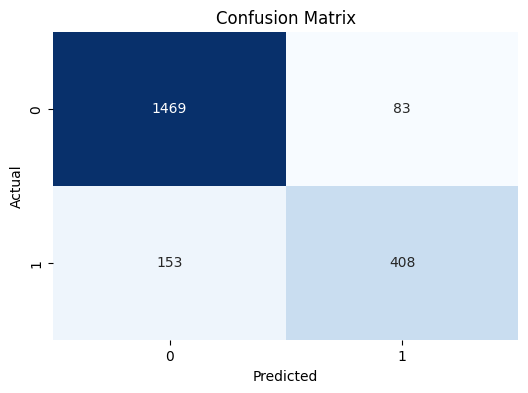

In [9]:
#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
import random
# Function to generate random data for prediction
def generate_sample_subsets(data, number_of_samples=100):
    #Minimum number of samples = 100
    #Maximum number of samples = 2000
    l = list()
    minimum_samples = 500
    maximum_samples = 2000
    for _ in range(number_of_samples):
        
        sample_size = random.randint(minimum_samples, maximum_samples)
        random_start_location = random.randint(0, data.shape[0] - sample_size)
        generated_dataframe = data.iloc[random_start_location:random_start_location + sample_size]
        a = generated_dataframe.copy()
        l.append(a)

    return l

In [11]:
random_samples = generate_sample_subsets(data, number_of_samples=100)

In [12]:
y.dtype

dtype('int64')

In [13]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
best_neighbors = []
best_f1_scores = []
median_neighbor_distance = []
model_instance_list = []
dataset_sizes = []

i = 0

for df in random_samples:
    params = {"n_neighbors" : np.arange(3, 101, 2)}
    knn = KNeighborsClassifier()
    f1_scorer = make_scorer(f1_score, average='macro', zero_division=0)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    model = GridSearchCV(knn, params, scoring='f1_macro', cv=3, n_jobs=-1)
    X = df.drop(['churn_value'], axis=1)
    y = df['churn_value']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    best_k = model.best_params_['n_neighbors']

    best_neighbors.append(model.best_params_['n_neighbors'])
    best_f1_scores.append(f1_score(y_test, y_pred))
    model_instance_list.append(model)

    #Compute median k -NN distances in training set
    nbrs = KNeighborsClassifier(n_neighbors=best_k)
    nbrs.fit(X_train, y_train)
    distances, indices = nbrs.kneighbors(X_train)

    #Remove self distance
    distances_no_self = distances[:, 1:]
    median_distance = np.median(distances_no_self)
    median_neighbor_distance.append(median_distance)

    dataset_sizes.append(df.shape[0])
    i += 1
    if(i % 10 == 0):
        print(f"Processed {i} samples")



Processed 10 samples
Processed 20 samples
Processed 30 samples
Processed 40 samples
Processed 50 samples
Processed 60 samples
Processed 70 samples
Processed 80 samples
Processed 90 samples
Processed 100 samples


In [15]:
metrics_df = pd.DataFrame({
    'optimal_k_value': best_neighbors,
    'best_f1_scores': best_f1_scores,
    'median_neighbor_distance': median_neighbor_distance,
    'model_instance' : model_instance_list,
    'dataset_size' : dataset_sizes
})


metrics_df = metrics_df[metrics_df['best_f1_scores'] != 0]
metrics_df.head()

,optimal_k_value,best_f1_scores,median_neighbor_distance,model_instance,dataset_size
3,3,0.833333,1.001769,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1217
6,35,0.826446,1.481423,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",792
8,25,0.866450,1.436976,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1096
11,15,0.685121,1.167306,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1798
14,69,0.861878,1.531761,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1252


In [16]:
metrics_df["optimal_k_value"].value_counts().sort_index()

optimal_k_value
3     12
5      1
7      8
9      5
11     3
13     2
15     2
17     1
19     2
21     1
23     2
25     1
27     1
29     2
35     1
53     1
59     1
65     1
69     1
Name: count, dtype: int64

In [17]:
min_median_distance = metrics_df['median_neighbor_distance'].min()
max_median_distance = metrics_df['median_neighbor_distance'].max()
mean_median_distance = metrics_df['median_neighbor_distance'].mean()
print(f"Min Median Distance: {min_median_distance}")
print(f"Max Median Distance: {max_median_distance}")
print(f"Mean Median Distance: {mean_median_distance}")

Min Median Distance: 0.566212900472154
Max Median Distance: 1.6305892716084274
Mean Median Distance: 1.125382081687486


In [18]:
def assign_score(distance, min_distance, max_distance):
    score = 0.5 + (np.arctan(((max_distance + min_distance)/2) - distance)/np.pi)
    return score

In [19]:
assigned_scores = []
metrics_df["assigned_score"] = metrics_df["median_neighbor_distance"].apply(lambda x: assign_score(x, min_median_distance, max_median_distance))
metrics_df.head()

,optimal_k_value,best_f1_scores,median_neighbor_distance,model_instance,dataset_size,assigned_score
3,3,0.833333,1.001769,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1217,0.530664
6,35,0.826446,1.481423,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",792,0.383567
8,25,0.866450,1.436976,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1096,0.396084
11,15,0.685121,1.167306,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1798,0.478102
14,69,0.861878,1.531761,"GridSearchCV(cv=3, estimator=KNeighborsClassif...",1252,0.369833


In [38]:
#testing for a random sample point from the dataset
random_index = random.randint(0, data.shape[0]-1)
random_data_point = data.iloc[random_index].drop(['churn_value']).values.reshape(1, -1)


In [39]:
#run the data point through all models and get the weighted prediction based on assigned_scores

probabilities = []
for index, row in metrics_df.iterrows():
    model = row['model_instance']
    prob = model.predict_proba(random_data_point)[0]

    # Ensure we always have [P(class 0), P(class 1)]
    full_prob = np.zeros(2)
    for i, cls in enumerate(model.classes_):
        full_prob[int(cls)] = prob[i]

    probabilities.append(full_prob)


probabilities = np.array(probabilities)
probabilities

array([[0.33333333, 0.66666667],
       [0.62857143, 0.37142857],
       [0.24      , 0.76      ],
       [0.53333333, 0.46666667],
       [0.36231884, 0.63768116],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.27272727, 0.72727273],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.42857143, 0.57142857],
       [0.17391304, 0.82608696],
       [0.29411765, 0.70588235],
       [0.        , 1.        ],
       [0.14285714, 0.85714286],
       [0.71428571, 0.28571429],
       [0.31034483, 0.68965517],
       [0.38983051, 0.61016949],
       [0.        , 1.        ],
       [0.30769231, 0.69230769],
       [0.        , 1.        ],
       [0.46153846, 0.53846154],
       [0.84210526, 0.15789474],
       [0.45454545, 0.54545455],
       [0.26153846, 0.73846154],
       [0.        , 1.        ],
       [0.06666667, 0.93333333],
       [0.

In [40]:
approach_1 = probabilities * metrics_df['assigned_score'].values.reshape(-1, 1)
final_output_approach_1 = (approach_1.sum(axis=0)) / metrics_df['assigned_score'].sum()
final_output_approach_1

array([0.26295356, 0.73704644])

In [41]:
approach_2 = probabilities * (metrics_df['dataset_size']).values.reshape(-1, 1)
final_output_approach_2 = (approach_2.sum(axis=0)) / (metrics_df['dataset_size']).sum()
final_output_approach_2

array([0.29507208, 0.70492792])

In [42]:
#original probability
optimal_knn.predict_proba(random_data_point)[0]

array([0.33333333, 0.66666667])

In [43]:
#actual classification
data.iloc[random_index]['churn_value']

np.float64(1.0)